In [1]:
%matplotlib inline
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import medial_axis, skeletonize
from skan import skeleton_to_csgraph, _testdata, draw, Skeleton, summarize

sys.path.insert(0, os.path.abspath('../'))
from src.lib import centroids as centutils

plt.rcParams['figure.figsize'] = [15, 15]

/home/juanjo/VirtualEnvs/Fondef/lib/python3.8/site-packages/skan/csr.py:21: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @numba.jitclass(csr_spec)


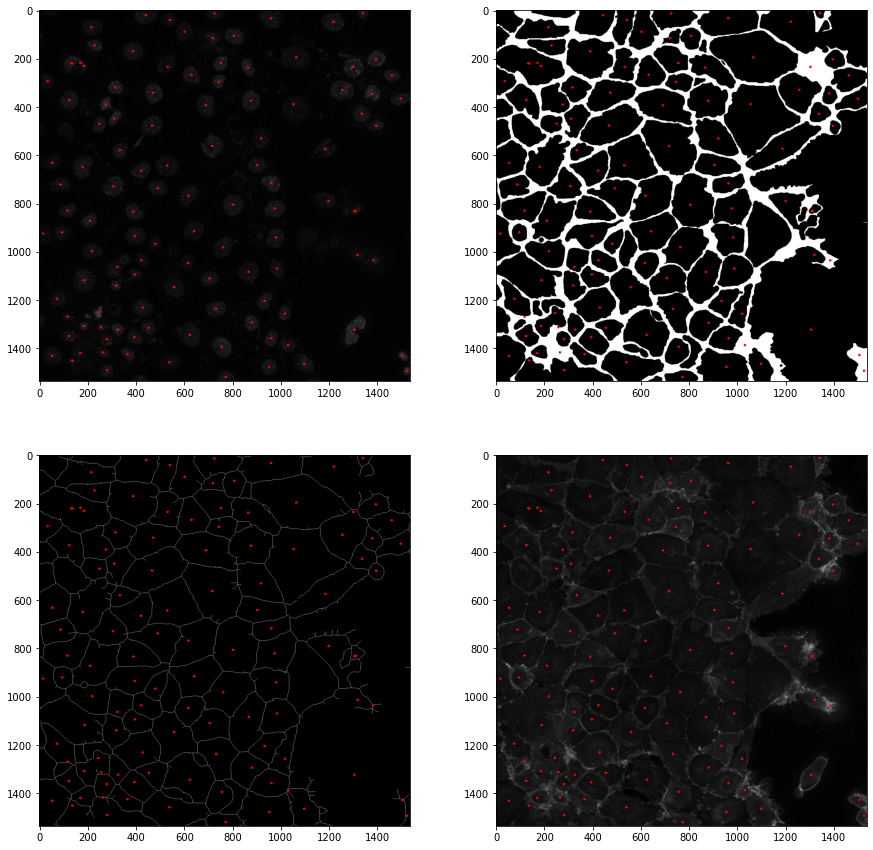

In [2]:
nuclei_path = '../data/first/Nuclei/AKT1_B1_CAn.tif'
jbin_path = '../data/first/Segmented/AKT1_B1_CAj-BI.tif'
jsk_path = '../data/first/Skeletonized/AKT1_B1_CAj-SK.tif'
j_path = '../data/first/Original/AKT1_B1_CAj.tif'

nuclei_img = cv2.imread(nuclei_path)
jbin_img = cv2.imread(jbin_path)
jsk_img = cv2.imread(jsk_path)
j_img = cv2.imread(j_path)

centroids = centutils.get_nuclei_centroids(nuclei_img)

nuclei_centroids = nuclei_img.copy()
jbin_centroids = jbin_img.copy()
jsk_centroids = jsk_img.copy()
j_centroids = j_img.copy()


for x, y in centroids:
    cv2.circle(nuclei_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(jbin_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(jsk_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(j_centroids, (x, y), 5, (255, 0, 0), -1)

    
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(nuclei_centroids)
ax[0,1].imshow(jbin_centroids)
ax[1,0].imshow(jsk_centroids)
ax[1,1].imshow(j_centroids)



In [3]:
jbin_img_gray = cv2.cvtColor(jbin_img, cv2.COLOR_BGR2GRAY)

skel, distance = medial_axis(jbin_img_gray, return_distance=True)

In [4]:
dist_on_skel = distance * skel

(-0.5, 1535.5, 1535.5, -0.5)

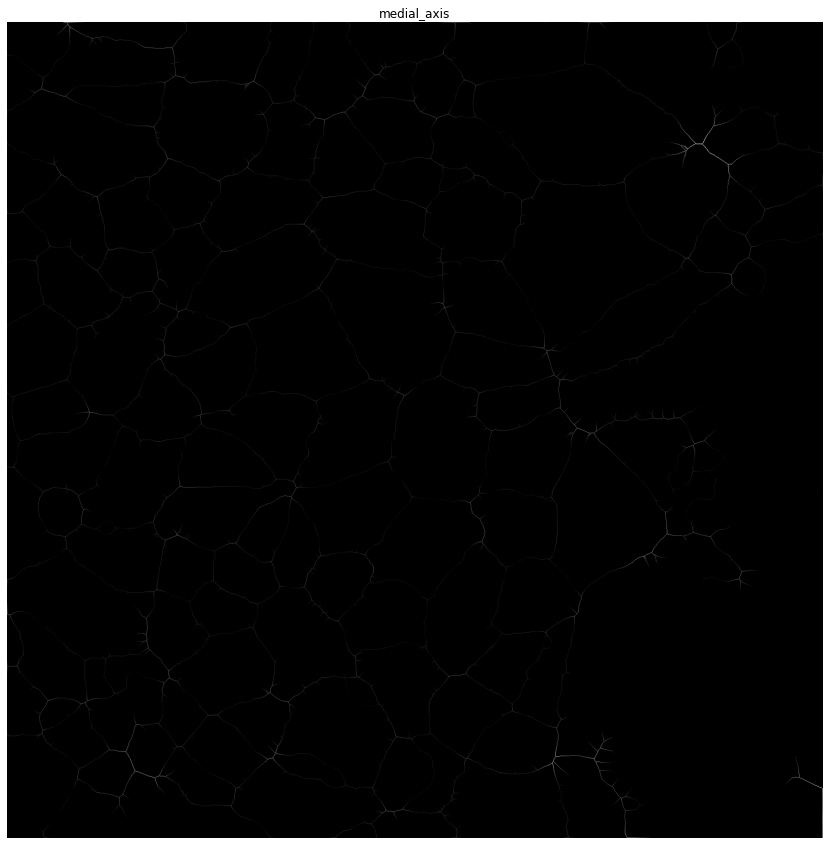

In [5]:
plt.imshow(dist_on_skel, cmap='gray')
plt.title('medial_axis')
plt.axis('off')

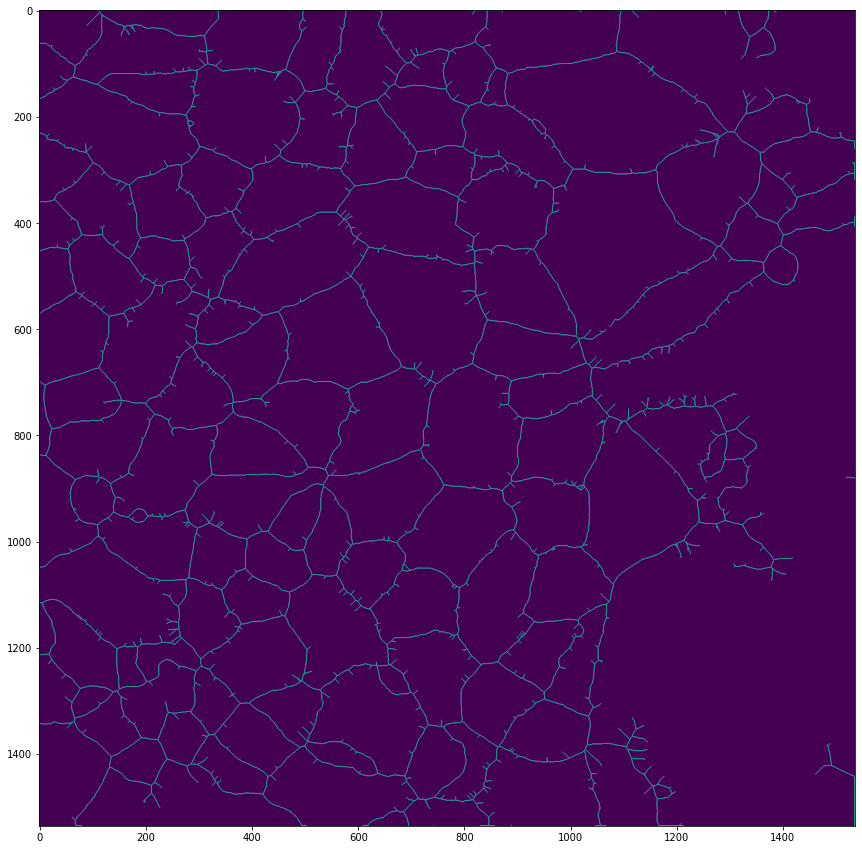

In [6]:
plt.imshow(skel)

In [7]:
skeleton = Skeleton(skel)

In [8]:
def get_branch_width(path, coords, distances_img):
    distances = []
    for p in path:
        i, j = coords[p]
        distances.append(distances_img[i, j])
    distances = np.array(distances)
    return distances.mean(), distances.std()
    
def get_branches_width_data(skeleton, distances_img):
    """
    For each branch in the skeleton, computes its mean width and its standard deviation.
    """
    means = []
    stds = []
    coords = skeleton.coordinates.astype(int)
    for i in range(skeleton.paths.shape[0]):
        start, stop = skeleton.paths.indptr[i:i+2]
        path = skeleton.paths.indices[start:stop]
        mean, std = get_branch_width(path, coords, distances_img)
        means.append(mean)
        stds.append(std)
    return means, stds

In [9]:
means, stds = get_branches_width_data(skeleton, dist_on_skel)

In [10]:
branch_data = summarize(skeleton)

In [11]:
branch_data

skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0               1            1          240         6.414214            1   
1               1           40          240        34.414214            1   
2               1           41          691        70.012193            1   
3               3           53           56         3.000000            0   
4               1           57          351        22.356527            1   
...           ...          ...          ...              ...          ...   
1725            1        17082        32944         8.414214            1   
1726           94        19137        19204        16.828427            0   
1727          415        25184        25280         4.000000            0   
1728          793        32768        32818         5.000000            0   
1729          795        32813        32878         1.000000            0   

      mean-pixel-value  stdev-pixel-value  image-coord-src-0  \
0                  1.0                0.0                0.0   
1                  1.0                0.0                0.0   
2                  1.0                0.0                0.0   
3                  1.0                0.0                0.0   
4                  1.0                0.0                0.0   
...                ...                ...                ...   
1725               1.0                0.0             1534.0   
1726               1.0                0.0              879.0   
1727               1.0                0.0             1172.0   
1728               1.0                0.0             1530.0   
1729               1.0                0.0             1534.0   

      image-coord-src-1  image-coord-dst-0  image-coord-dst-1  coord-src-0  \
0                 106.0           1.000000         112.000000          0.0   
1                 146.0           1.000000         112.000000          0.0   
2                 325.0          48.000000         310.000000          0.0   
3                 469.0           0.000000         472.000000          0.0   
4                 492.0          16.666667         496.333333          0.0   
...                 ...                ...                ...          ...   
1725             1205.0        1535.000000        1213.000000       1534.0   
1726             1519.0         881.000000        1535.000000        879.0   
1727                0.0        1176.000000           0.000000       1172.0   
1728                0.0        1535.000000           0.000000       1530.0   
1729              889.0        1535.000000         889.000000       1534.0   

      coord-src-1  coord-dst-0  coord-dst-1  euclidean-distance  
0           106.0     1.000000   112.000000            6.082763  
1           146.0     1.000000   112.000000           34.014703  
2           325.0    48.000000   310.000000           50.289164  
3           469.0     0.000000   472.000000            3.000000  
4           492.0    16.666667   496.333333           17.220788  
...           ...          ...          ...                 ...  
1725       1205.0  1535.000000  1213.000000            8.062258  
1726       1519.0   881.000000  1535.000000           16.124515  
1727          0.0  1176.000000     0.000000            4.000000  
1728          0.0  1535.000000     0.000000            5.000000  
1729        889.0  1535.000000   889.000000            1.000000  

[1730 rows x 16 columns]

In [12]:
branch_data['mean-width'] = means

In [13]:
branch_data['std-width'] = stds

In [14]:
branch_data

skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0               1            1          240         6.414214            1   
1               1           40          240        34.414214            1   
2               1           41          691        70.012193            1   
3               3           53           56         3.000000            0   
4               1           57          351        22.356527            1   
...           ...          ...          ...              ...          ...   
1725            1        17082        32944         8.414214            1   
1726           94        19137        19204        16.828427            0   
1727          415        25184        25280         4.000000            0   
1728          793        32768        32818         5.000000            0   
1729          795        32813        32878         1.000000            0   

      mean-pixel-value  stdev-pixel-value  image-coord-src-0  \
0                  1.0                0.0                0.0   
1                  1.0                0.0                0.0   
2                  1.0                0.0                0.0   
3                  1.0                0.0                0.0   
4                  1.0                0.0                0.0   
...                ...                ...                ...   
1725               1.0                0.0             1534.0   
1726               1.0                0.0              879.0   
1727               1.0                0.0             1172.0   
1728               1.0                0.0             1530.0   
1729               1.0                0.0             1534.0   

      image-coord-src-1  image-coord-dst-0  image-coord-dst-1  coord-src-0  \
0                 106.0           1.000000         112.000000          0.0   
1                 146.0           1.000000         112.000000          0.0   
2                 325.0          48.000000         310.000000          0.0   
3                 469.0           0.000000         472.000000          0.0   
4                 492.0          16.666667         496.333333          0.0   
...                 ...                ...                ...          ...   
1725             1205.0        1535.000000        1213.000000       1534.0   
1726             1519.0         881.000000        1535.000000        879.0   
1727                0.0        1176.000000           0.000000       1172.0   
1728                0.0        1535.000000           0.000000       1530.0   
1729              889.0        1535.000000         889.000000       1534.0   

      coord-src-1  coord-dst-0  coord-dst-1  euclidean-distance  mean-width  \
0           106.0     1.000000   112.000000            6.082763   31.916421   
1           146.0     1.000000   112.000000           34.014703   17.062199   
2           325.0    48.000000   310.000000           50.289164   10.007495   
3           469.0     0.000000   472.000000            3.000000    1.000000   
4           492.0    16.666667   496.333333           17.220788    3.951889   
...           ...          ...          ...                 ...         ...   
1725       1205.0  1535.000000  1213.000000            8.062258    3.815243   
1726       1519.0   881.000000  1535.000000           16.124515    1.000000   
1727          0.0  1176.000000     0.000000            4.000000    1.000000   
1728          0.0  1535.000000     0.000000            5.000000    1.069036   
1729        889.0  1535.000000   889.000000            1.000000    1.000000   

      std-width  
0      1.158470  
1      9.969736  
2      4.466737  
3      0.000000  
4      1.155403  
...         ...  
1725   2.027459  
1726   0.000000  
1727   0.000000  
1728   0.154368  
1729   0.000000  

[1730 rows x 18 columns]

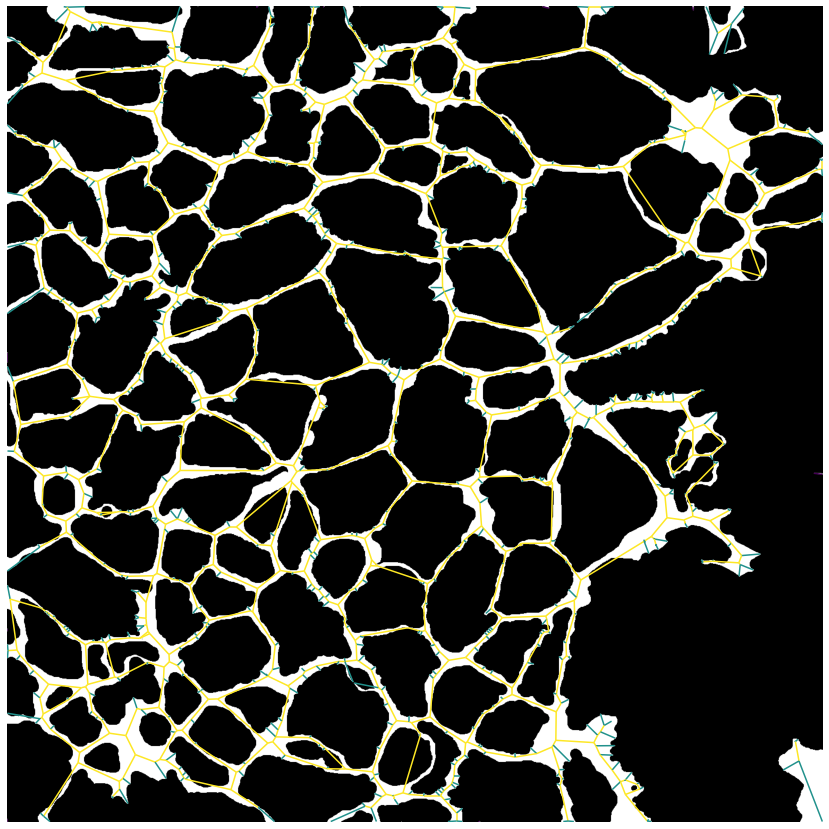

In [15]:
draw.overlay_euclidean_skeleton_2d(jbin_img, branch_data, skeleton_color_source='branch-type')

In [16]:
def draw_lines(df, image, color, thickness=5):
    copy = image.copy()
    for index, row in df.iterrows():
        x0 = int(row['image-coord-src-0'])
        y0 = int(row['image-coord-src-1'])
        x1 = int(row['image-coord-dst-0'])
        y1 = int(row['image-coord-dst-1'])
        cv2.line(copy, (y0, x0), (y1, x1), color, thickness)
    return copy

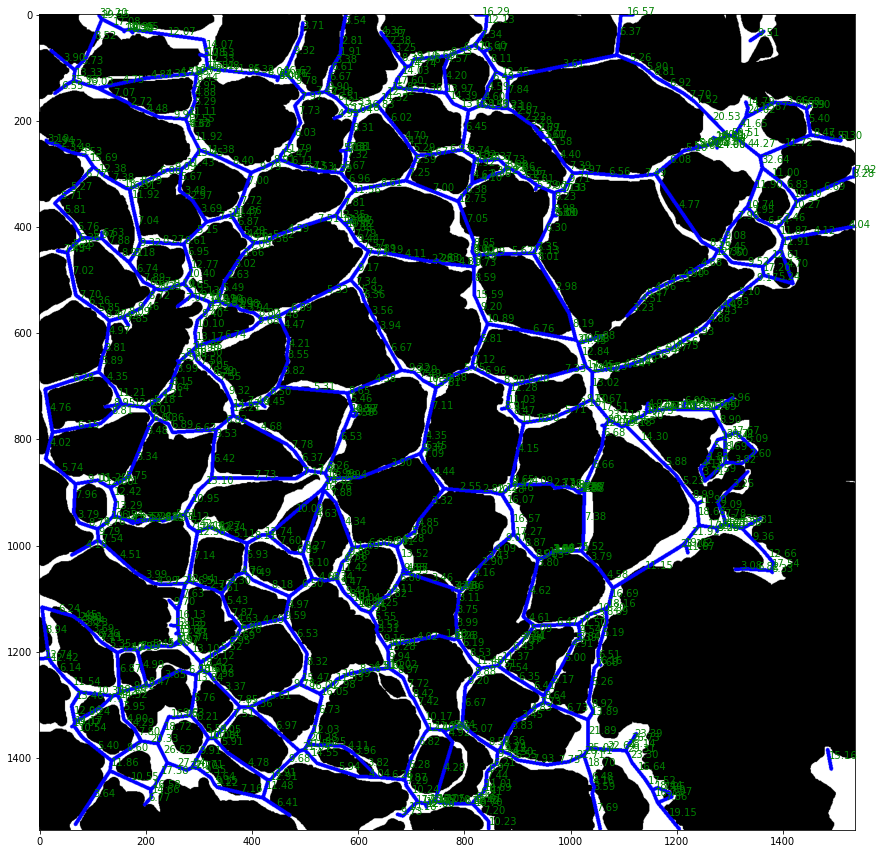

In [17]:
j2j_df = branch_data[branch_data['branch-type'] == 2]
j2j_img = draw_lines(j2j_df, jbin_img, (0, 0, 255))
fig, ax = plt.subplots()
for _, row in j2j_df.iterrows():
    x0 = int(row['image-coord-src-0'])
    y0 = int(row['image-coord-src-1'])
    x1 = int(row['image-coord-dst-0'])
    y1 = int(row['image-coord-dst-1'])
    x = (x0 + x1) / 2
    y = (y0 + y1) /2
    ax.text(y,x, '{:.2f}'.format(row['mean-width']), color='green')

ax.imshow(j2j_img)

In [73]:
def get_coords_path(path, coords, degrees):
    ret = [coords[p] for p in path]
    if degrees[path[0]] >= 2:
        ret = ret[1:]
    else:
        ret = ret[:-1]
    return ret

def get_j2e_branches_coords(skeleton, df, min_length):
    """
    For each branch in the skeleton, computes its mean width and its standard deviation.
    """
    
    df_filtered = df[df['branch-distance'] < min_length]
    print(len(df_filtered))
    coords_skel = skeleton.coordinates.astype(int)
    coords_j2e = []
    for index, row in df_filtered.iterrows():
        print(index)
        start, stop = skeleton.paths.indptr[index:index+2]
        path = skeleton.paths.indices[start:stop]
        result = get_coords_path(path, coords_skel, skeleton.degrees)
        coords_j2e += result
    return coords_j2e

In [52]:
j2e_df = branch_data[branch_data['branch-type'] == 1]
min_length = 50
to_erase = get_j2e_branches_coords(skeleton, j2e_df, min_length)

718


In [53]:
j2e_df[j2e_df['branch-distance'] < 10]

skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0               1            1          240         6.414214            1   
5               1           62          243         7.414214            1   
18              1          245          331         8.485281            1   
30              1          351          504         7.377015            1   
38              1          452          800         7.071068            1   
...           ...          ...          ...              ...          ...   
1713            1        17035        32525         2.134375            1   
1718            1        17040        32659         8.485281            1   
1722            1        17061        32879         9.414214            1   
1724            1        17082        32785         4.242641            1   
1725            1        17082        32944         8.414214            1   

      mean-pixel-value  stdev-pixel-value  image-coord-src-0  \
0                  1.0                0.0           0.000000   
5                  1.0                0.0           0.000000   
18                 1.0                0.0           1.000000   
30                 1.0                0.0          16.666667   
38                 1.0                0.0          31.000000   
...                ...                ...                ...   
1713               1.0                0.0        1508.666667   
1718               1.0                0.0        1525.000000   
1722               1.0                0.0        1534.000000   
1724               1.0                0.0        1534.000000   
1725               1.0                0.0        1534.000000   

      image-coord-src-1  image-coord-dst-0  image-coord-dst-1  coord-src-0  \
0            106.000000                1.0              112.0     0.000000   
5            570.000000                1.0              577.0     0.000000   
18           821.000000                7.0              815.0     1.000000   
30           496.333333               21.0              502.0    16.666667   
38           840.000000               36.0              845.0    31.000000   
...                 ...                ...                ...          ...   
1713         472.666667             1507.0              474.0  1508.666667   
1718          68.000000             1519.0               62.0  1525.000000   
1722        1056.000000             1535.0             1047.0  1534.000000   
1724        1205.000000             1531.0             1208.0  1534.000000   
1725        1205.000000             1535.0             1213.0  1534.000000   

      coord-src-1  coord-dst-0  coord-dst-1  euclidean-distance  mean-width  \
0      106.000000          1.0        112.0            6.082763   31.916421   
5      570.000000          1.0        577.0            7.071068    3.636397   
18     821.000000          7.0        815.0            8.485281    4.611256   
30     496.333333         21.0        502.0            7.133645    3.318107   
38     840.000000         36.0        845.0            7.071068    3.638804   
...           ...          ...          ...                 ...         ...   
1713   472.666667       1507.0        474.0            2.134375    0.500000   
1718    68.000000       1519.0         62.0            8.485281    4.602925   
1722  1056.000000       1535.0       1047.0            9.055385    8.311548   
1724  1205.000000       1531.0       1208.0            4.242641    5.517767   
1725  1205.000000       1535.0       1213.0            8.062258    3.815243   

      std-width  
0      1.158470  
5      1.877930  
18     2.567773  
30     1.578027  
38     1.850884  
...         ...  
1713   0.500000  
1718   2.554872  
1722   2.195034  
1724   1.142037  
1725   2.027459  

[483 rows x 18 columns]

In [54]:
to_erase = np.array(to_erase)
to_erase_coords = (to_erase[:,0], to_erase[:,1])
skel2 = skel.copy()
print(len(skel2.nonzero()[0]))
skel2[to_erase_coords] = 0
print(len(skel2.nonzero()[0]))

32945
27612


In [55]:
to_erase_coords

(array([   0,    0,    0, ..., 1535, 1535, 1535]),
 array([ 106,  107,  108, ..., 1211, 1212, 1213]))

In [70]:
len(skel2.nonzero()[0]), len(skel.nonzero()[0])

(27612, 32945)

In [57]:
to_erase[:10]

array([[  0, 106],
       [  0, 107],
       [  0, 108],
       [  0, 109],
       [  0, 110],
       [  0, 111],
       [  0, 146],
       [  0, 145],
       [  0, 144],
       [  0, 143]])

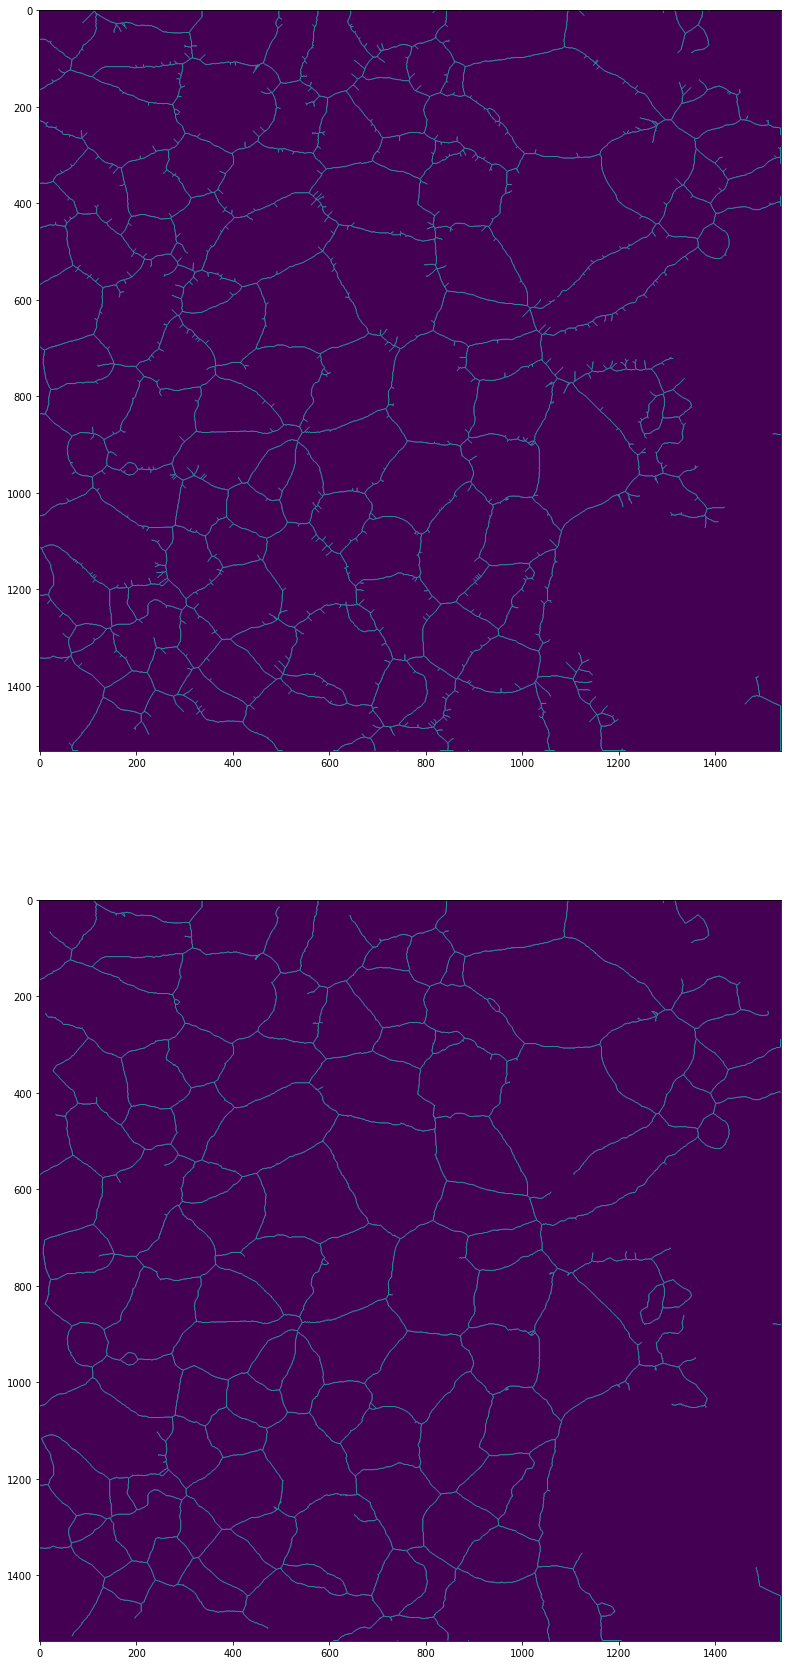

In [58]:
fig, axes = plt.subplots(2, figsize=(15,30))
axes[0].imshow(skel)
axes[1].imshow(skel2)

In [59]:
skeleton2 = Skeleton(skel2)
means2, stds2 = get_branches_width_data(skeleton2, dist_on_skel)
branch_data2 = summarize(skeleton2)

In [60]:
branch_data2['mean-width'] = means2
branch_data2['std-width'] = stds2

In [61]:
len(means2)

926

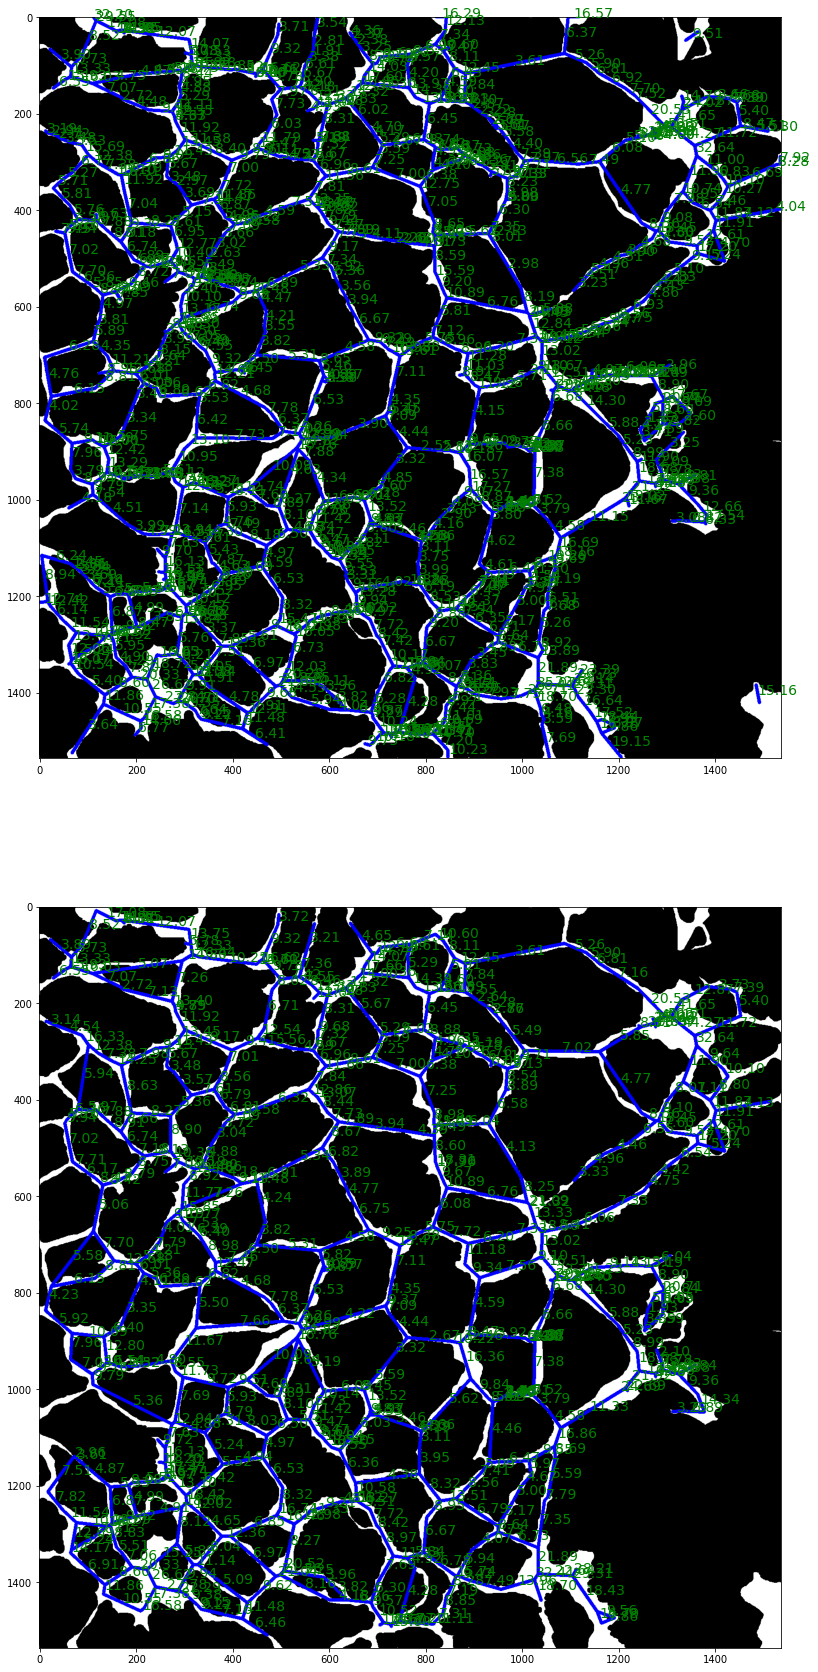

In [62]:
j2j_df2 = branch_data2[branch_data2['branch-type'] == 2]
j2j_img2 = draw_lines(j2j_df2, jbin_img, (0, 0, 255))
fig, ax = plt.subplots(2, figsize=(15,30))
for index, row in j2j_df.iterrows():
    x0 = int(row['image-coord-src-0'])
    y0 = int(row['image-coord-src-1'])
    x1 = int(row['image-coord-dst-0'])
    y1 = int(row['image-coord-dst-1'])
    x = (x0 + x1) / 2
    y = (y0 + y1) / 2
    ax[0].text(y,x, '{:.2f}'.format(row['mean-width']), color='green', fontsize=14)

for index, row in j2j_df2.iterrows():
    x0 = int(row['image-coord-src-0'])
    y0 = int(row['image-coord-src-1'])
    x1 = int(row['image-coord-dst-0'])
    y1 = int(row['image-coord-dst-1'])
    x = (x0 + x1) / 2
    y = (y0 + y1) / 2
    ax[1].text(y,x, '{:.2f}'.format(row['mean-width']), color='green', fontsize=14)

ax[0].imshow(j2j_img)    
ax[1].imshow(j2j_img2)

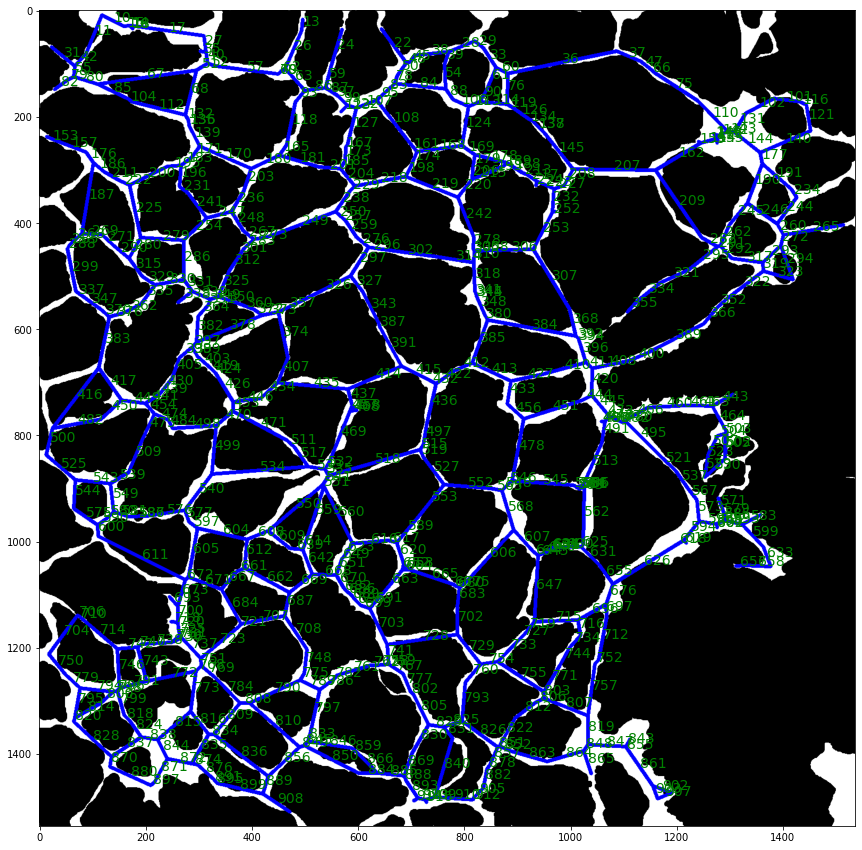

In [65]:
j2j_df2 = branch_data2[branch_data2['branch-type'] == 2]
j2j_img2 = draw_lines(j2j_df2, jbin_img, (0, 0, 255))

for index, row in j2j_df2.iterrows():
    x0 = int(row['image-coord-src-0'])
    y0 = int(row['image-coord-src-1'])
    x1 = int(row['image-coord-dst-0'])
    y1 = int(row['image-coord-dst-1'])
    x = (x0 + x1) / 2
    y = (y0 + y1) / 2
    plt.text(y,x, index, color='green', fontsize=14)

plt.imshow(j2j_img2)

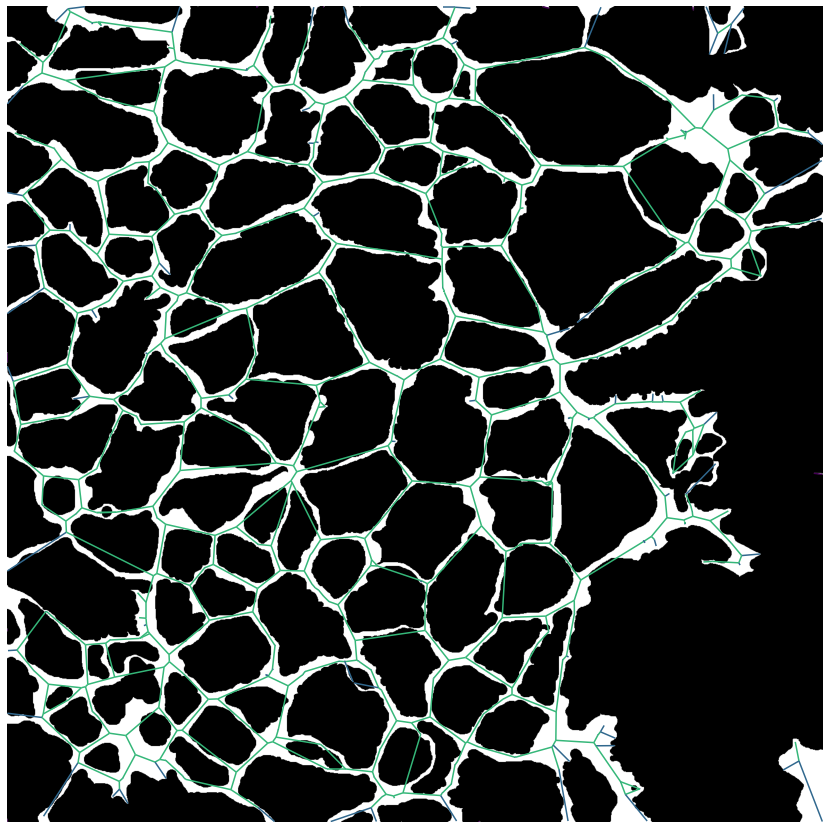

In [47]:
draw.overlay_euclidean_skeleton_2d(jbin_img, branch_data2, skeleton_color_source='branch-type')

In [48]:
branch_data2

skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0              1           34          194        38.242641            1   
1              1           35          615        70.012193            1   
2              3           47           50         3.000000            0   
3              4           51           53         2.000000            0   
4              1           54          514        49.091883            1   
..           ...          ...          ...              ...          ...   
956            1        14445        28336        30.142136            1   
957           80        16525        16590        16.828427            0   
958          271        21758        21833         4.000000            0   
959          503        28274        28316         5.000000            0   
960          504        28311        28338         1.000000            0   

     mean-pixel-value  stdev-pixel-value  image-coord-src-0  \
0                 1.0                0.0                0.0   
1                 1.0                0.0                0.0   
2                 1.0                0.0                0.0   
3                 1.0                0.0                0.0   
4                 1.0                0.0                0.0   
..                ...                ...                ...   
956               1.0                0.0             1509.0   
957               1.0                0.0              879.0   
958               1.0                0.0             1172.0   
959               1.0                0.0             1530.0   
960               1.0                0.0             1534.0   

     image-coord-src-1  image-coord-dst-0  image-coord-dst-1  coord-src-0  \
0                146.0                4.0              114.0          0.0   
1                325.0               48.0              310.0          0.0   
2                469.0                0.0              472.0          0.0   
3                595.0                0.0              597.0          0.0   
4                633.0               34.5              643.5          0.0   
..                 ...                ...                ...          ...   
956              685.0             1535.0              695.0       1509.0   
957             1519.0              881.0             1535.0        879.0   
958                0.0             1176.0                0.0       1172.0   
959                0.0             1535.0                0.0       1530.0   
960              889.0             1535.0              889.0       1534.0   

     coord-src-1  coord-dst-0  coord-dst-1  euclidean-distance  mean-width  \
0          146.0          4.0        114.0           32.249031   18.229452   
1          325.0         48.0        310.0           50.289164   10.007495   
2          469.0          0.0        472.0            3.000000    1.000000   
3          595.0          0.0        597.0            2.000000    1.000000   
4          633.0         34.5        643.5           36.062446    4.596374   
..           ...          ...          ...                 ...         ...   
956        685.0       1535.0        695.0           27.856777    6.973444   
957       1519.0        881.0       1535.0           16.124515    1.000000   
958          0.0       1176.0          0.0            4.000000    1.000000   
959          0.0       1535.0          0.0            5.000000    1.069036   
960        889.0       1535.0        889.0            1.000000    1.000000   

     std-width  
0    10.367089  
1     4.466737  
2     0.000000  
3     0.000000  
4     1.626674  
..         ...  
956   1.465897  
957   0.000000  
958   0.000000  
959   0.154368  
960   0.000000  

[961 rows x 18 columns]

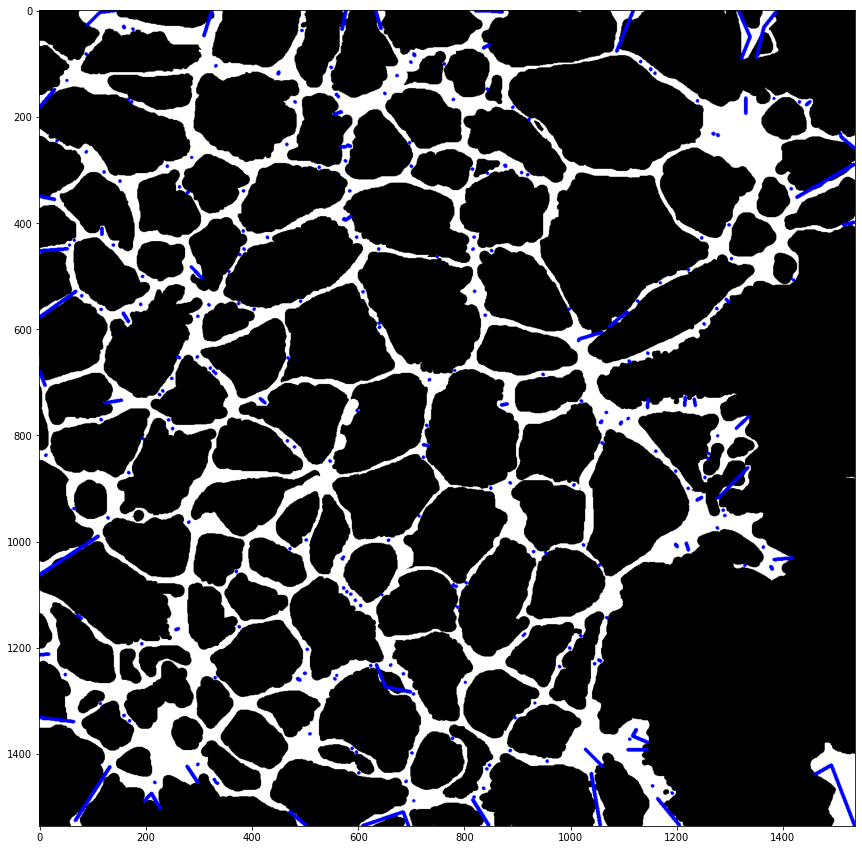

In [49]:
j2e_df2 = branch_data2[branch_data2['branch-type'] == 1]
j2e_img2 = draw_lines(j2e_df2, jbin_img, (0, 0, 255))
plt.imshow(j2e_img2)

In [50]:
j2e_df2

skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0              1           34          194        38.242641            1   
1              1           35          615        70.012193            1   
4              1           54          514        49.091883            1   
7              8          145          623        59.941125            1   
8              1          156          533        40.677670            1   
..           ...          ...          ...              ...          ...   
950            1        14437        27856         2.000000            1   
953            1        14442        28066         2.414214            1   
954            1        14442        28325        44.672833            1   
955            1        14445        28326        90.669048            1   
956            1        14445        28336        30.142136            1   

     mean-pixel-value  stdev-pixel-value  image-coord-src-0  \
0                 1.0                0.0                0.0   
1                 1.0                0.0                0.0   
4                 1.0                0.0                0.0   
7                 1.0                0.0                0.0   
8                 1.0                0.0                1.0   
..                ...                ...                ...   
950               1.0                0.0             1488.5   
953               1.0                0.0             1509.0   
954               1.0                0.0             1509.0   
955               1.0                0.0             1509.0   
956               1.0                0.0             1509.0   

     image-coord-src-1  image-coord-dst-0  image-coord-dst-1  coord-src-0  \
0                146.0                4.0              114.0          0.0   
1                325.0               48.0              310.0          0.0   
4                633.0               34.5              643.5          0.0   
7               1316.0               50.0             1338.0          0.0   
8                577.0               36.5              570.5          1.0   
..                 ...                ...                ...          ...   
950              705.5             1488.0              705.0       1488.5   
953              472.5             1508.0              473.0       1509.0   
954              472.5             1535.0              503.0       1509.0   
955              685.0             1535.0              609.0       1509.0   
956              685.0             1535.0              695.0       1509.0   

     coord-src-1  coord-dst-0  coord-dst-1  euclidean-distance  mean-width  \
0          146.0          4.0        114.0           32.249031   18.229452   
1          325.0         48.0        310.0           50.289164   10.007495   
4          633.0         34.5        643.5           36.062446    4.596374   
7         1316.0         50.0       1338.0           54.626001    6.458361   
8          577.0         36.5        570.5           36.090165    3.535856   
..           ...          ...          ...                 ...         ...   
950        705.5       1488.0        705.0            0.707107   14.000000   
953        472.5       1508.0        473.0            1.118034    2.118034   
954        472.5       1535.0        503.0           40.078049    4.076700   
955        685.0       1535.0        609.0           80.324343    7.465214   
956        685.0       1535.0        695.0           27.856777    6.973444   

     std-width  
0    10.367089  
1     4.466737  
4     1.626674  
7     3.596754  
8     1.553830  
..         ...  
950   0.000000  
953   0.118034  
954   1.660993  
955   2.035284  
956   1.465897  

[307 rows x 18 columns]

In [51]:
j2e_df2[j2e_df2['branch-distance'] < 2]

skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
30             1          515          636         1.414214            1   
81             1         1408         2262         1.618590            1   
126            1         1913         3216         1.414214            1   
186            1         2819         4956         1.414214            1   
322            1         4314         8941         1.414214            1   
616            1         9050        18063         1.414214            1   
623            1         9219        18322         1.414214            1   

     mean-pixel-value  stdev-pixel-value  image-coord-src-0  \
30                1.0                0.0               35.0   
81                1.0                0.0              120.0   
126               1.0                0.0              173.0   
186               1.0                0.0              267.0   
322               1.0                0.0              452.0   
616               1.0                0.0              963.0   
623               1.0                0.0              974.0   

     image-coord-src-1  image-coord-dst-0  image-coord-dst-1  coord-src-0  \
30          176.000000               36.0              177.0         35.0   
81          450.272727              119.0              449.0        120.0   
126         482.000000              172.0              481.0        173.0   
186          88.000000              266.0               89.0        267.0   
322         851.000000              453.0              852.0        452.0   
616         282.000000              964.0              281.0        963.0   
623        1276.000000              975.0             1277.0        974.0   

     coord-src-1  coord-dst-0  coord-dst-1  euclidean-distance  mean-width  \
30    176.000000         36.0        177.0            1.414214    4.500000   
81    450.272727        119.0        449.0            1.618590   12.500000   
126   482.000000        172.0        481.0            1.414214   11.500000   
186    88.000000        266.0         89.0            1.414214   12.973186   
322   851.000000        453.0        852.0            1.414214    5.500000   
616   282.000000        964.0        281.0            1.414214    9.250910   
623  1276.000000        975.0       1277.0            1.414214    6.500000   

     std-width  
30    0.500000  
81    0.500000  
126   0.500000  
186   0.443222  
322   0.500000  
616   0.648585  
623   0.500000

In [74]:
min_length = 10
to_erase2 = get_j2e_branches_coords(skeleton2, j2e_df2, min_length)

245
25
28
30
31
33
50
52
53
55
58
62
65
67
73
74
80
81
83
86
90
98
100
103
105
107
109
112
114
118
120
124
126
129
134
138
142
155
156
159
163
167
171
175
177
186
193
195
203
205
208
210
213
216
221
223
225
227
232
241
244
246
248
250
251
268
269
274
276
279
287
288
290
294
297
300
302
313
316
317
322
324
326
329
335
339
343
347
348
355
357
361
368
369
371
374
376
378
380
382
384
386
390
395
397
402
404
406
411
417
418
420
422
425
434
437
439
441
444
445
447
456
458
470
485
490
497
499
501
503
506
507
511
512
514
519
526
528
530
532
534
536
540
542
544
546
548
551
556
558
562
567
577
584
586
590
594
598
604
608
611
616
623
633
635
644
647
648
649
652
658
663
666
668
670
676
678
682
688
696
700
701
703
707
710
712
716
720
723
727
731
733
735
744
746
748
754
757
761
767
769
775
778
785
786
788
792
796
798
801
803
805
807
809
810
814
826
833
835
839
843
845
854
864
866
882
888
893
894
899
902
904
911
913
916
920
922
924
926


ValueError: not enough values to unpack (expected 2, got 1)

In [68]:
j2e_df2

skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0              1           34          194        38.242641            1   
1              1           35          615        70.012193            1   
4              1           54          514        49.091883            1   
7              8          145          623        59.941125            1   
8              1          156          533        40.677670            1   
..           ...          ...          ...              ...          ...   
950            1        14437        27856         2.000000            1   
953            1        14442        28066         2.414214            1   
954            1        14442        28325        44.672833            1   
955            1        14445        28326        90.669048            1   
956            1        14445        28336        30.142136            1   

     mean-pixel-value  stdev-pixel-value  image-coord-src-0  \
0                 1.0                0.0                0.0   
1                 1.0                0.0                0.0   
4                 1.0                0.0                0.0   
7                 1.0                0.0                0.0   
8                 1.0                0.0                1.0   
..                ...                ...                ...   
950               1.0                0.0             1488.5   
953               1.0                0.0             1509.0   
954               1.0                0.0             1509.0   
955               1.0                0.0             1509.0   
956               1.0                0.0             1509.0   

     image-coord-src-1  image-coord-dst-0  image-coord-dst-1  coord-src-0  \
0                146.0                4.0              114.0          0.0   
1                325.0               48.0              310.0          0.0   
4                633.0               34.5              643.5          0.0   
7               1316.0               50.0             1338.0          0.0   
8                577.0               36.5              570.5          1.0   
..                 ...                ...                ...          ...   
950              705.5             1488.0              705.0       1488.5   
953              472.5             1508.0              473.0       1509.0   
954              472.5             1535.0              503.0       1509.0   
955              685.0             1535.0              609.0       1509.0   
956              685.0             1535.0              695.0       1509.0   

     coord-src-1  coord-dst-0  coord-dst-1  euclidean-distance  mean-width  \
0          146.0          4.0        114.0           32.249031   18.229452   
1          325.0         48.0        310.0           50.289164   10.007495   
4          633.0         34.5        643.5           36.062446    4.596374   
7         1316.0         50.0       1338.0           54.626001    6.458361   
8          577.0         36.5        570.5           36.090165    3.535856   
..           ...          ...          ...                 ...         ...   
950        705.5       1488.0        705.0            0.707107   14.000000   
953        472.5       1508.0        473.0            1.118034    2.118034   
954        472.5       1535.0        503.0           40.078049    4.076700   
955        685.0       1535.0        609.0           80.324343    7.465214   
956        685.0       1535.0        695.0           27.856777    6.973444   

     std-width  
0    10.367089  
1     4.466737  
4     1.626674  
7     3.596754  
8     1.553830  
..         ...  
950   0.000000  
953   0.118034  
954   1.660993  
955   2.035284  
956   1.465897  

[307 rows x 18 columns]

In [75]:
j2e_df2.loc[926]

skeleton-id               1.000000
node-id-src           14084.000000
node-id-dst           27269.000000
branch-distance           2.414214
branch-type               1.000000
mean-pixel-value          1.000000
stdev-pixel-value         0.000000
image-coord-src-0      1453.500000
image-coord-src-1       217.000000
image-coord-dst-0      1454.000000
image-coord-dst-1       218.000000
coord-src-0            1453.500000
coord-src-1             217.000000
coord-dst-0            1454.000000
coord-dst-1             218.000000
euclidean-distance        1.118034
mean-width               15.132169
std-width                 0.132169
Name: 926, dtype: float64

In [82]:
len(skeleton2.paths.indptr)

927